In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])
df = pyam.IamDataFrame(paper_data)
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1871 scenarios


In [4]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [5]:
kyoto_gases_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases'

# Figure 2A

In [6]:
variables = [
    kyoto_gases_variable,
]
quantiles = (0.1, 0.25, 0.5, 0.75, 0.9)
year_start, year_end = 2010, 2100

data = pyam.concat([
    (
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Category=category)
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .compute.quantiles(quantiles)
        .rename(model={'Quantiles': temp})
    ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
])

for variable in variables:
    data.append(
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .compute.quantiles(quantiles)
        .rename(model={'Quantiles': 'Current Policies'}),
        inplace=True
    )

In [7]:
# taken from p17, row 'Global emissions, including the impact of overachievement of NDCs *' of den Elzen 2022 SI
targets = pd.DataFrame([
    ('Current Policies (den Elzen 2022, adj.)', 56.826, 52.592, 59.552, 'dimgrey', 0),
    ('Conditional NDCs (den Elzen 2022, adj.)', 50.700, 48.542, 52.202, 'plum', -0.35),
    ('Unconditional NDCs (den Elzen 2022, adj.)', 52.284, 50.059, 54.136, 'thistle', 0.35),
], columns=['label', 'med', 'min', 'max', 'color', 'jitter'])

target_2015_value = 51.181 # to adjust for differences in LULUCF definitions, we take an offset of values used in den Elzen per conversations with Niklas Forsell
this_study_2015_value = (
    data
    .filter(variable=kyoto_gases_variable, year=2015, scenario='0.5')
    .timeseries()
    .mean()
    .iloc[0]
)
target_offset = target_2015_value - this_study_2015_value
target_2015_value, this_study_2015_value, target_offset

(51.181, 50.875938917628766, 0.30506108237123186)

In [8]:
color_map = {
    'Current Policies': pyam.plotting.PYAM_COLORS["AR6-IP-CurPol"],
    '2C': pyam.plotting.PYAM_COLORS["AR6-C3"],
    '1.5C': pyam.plotting.PYAM_COLORS["AR6-C1"], 
}
rc = pyam.run_control()
#rc.store['color']['model'] = {}
rc.update({'color': {'model': color_map}})

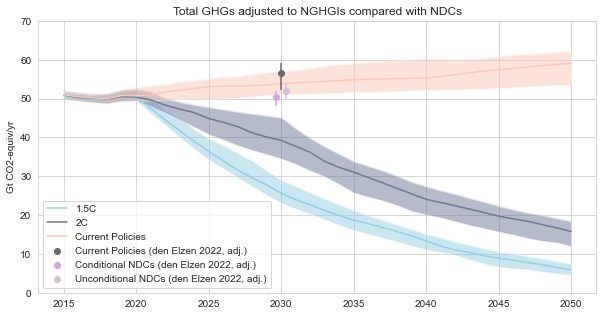

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between={'alpha': 0.5}, ax=ax, alpha=0.1)
)
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario='0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')
ax.set_ylim(0, 70)

fig.savefig('./files/figsi3a.svg', dpi=1200, bbox_inches='tight')

(-10.0, 80.0)

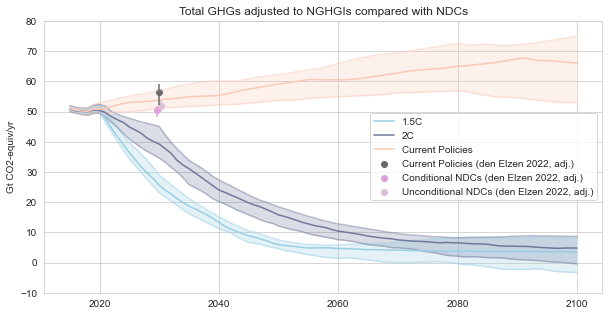

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2101))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, alpha=0.5)
)
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2101))
    .filter(scenario='0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')
ax.set_ylim(-10, 80)

## Gap quantification

In [11]:
med_target = targets.set_index('label')['med'] - target_offset
med_target

label
Current Policies (den Elzen 2022, adj.)      56.520939
Conditional NDCs (den Elzen 2022, adj.)      50.394939
Unconditional NDCs (den Elzen 2022, adj.)    51.978939
Name: med, dtype: float64

In [12]:
pathways = (
    data
    .filter(variable=kyoto_gases_variable, year=2030, scenario=['*0.5*'])
    .timeseries()
    [2030]
    .unstack('model')
    .reset_index(drop=True)
)
pathways

model,1.5C,2C,Current Policies
0,25.603602,39.248306,53.865272


In [13]:
gap = pd.DataFrame({c: med_target - float(pathways[c]) for c in pathways})
# gap.loc[-2:, 'Current Policies'] = np.nan
gap

C:\Users\gidden\AppData\Local\Temp\ipykernel_27960\1410993698.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gap = pd.DataFrame({c: med_target - float(pathways[c]) for c in pathways})


,1.5C,2C,Current Policies
label,,,
"Current Policies (den Elzen 2022, adj.)",30.917337,17.272633,2.655667
"Conditional NDCs (den Elzen 2022, adj.)",24.791337,11.146633,-3.470333
"Unconditional NDCs (den Elzen 2022, adj.)",26.375337,12.730633,-1.886333


In [14]:
# values in 2030
estimates_den_elzen = {
    '2C': 41.5, # 66% chance
    '1.5C': 24.7,
}
for key, value in estimates_den_elzen.items():
    gap[f'{key} (den Elzen 2022, adj.)'] = med_target - (value - target_offset)

In [15]:
gap

,1.5C,2C,Current Policies,"2C (den Elzen 2022, adj.)","1.5C (den Elzen 2022, adj.)"
label,,,,,
"Current Policies (den Elzen 2022, adj.)",30.917337,17.272633,2.655667,15.326,32.126
"Conditional NDCs (den Elzen 2022, adj.)",24.791337,11.146633,-3.470333,9.200,26.000
"Unconditional NDCs (den Elzen 2022, adj.)",26.375337,12.730633,-1.886333,10.784,27.584


In [16]:
gap.columns

Index(['1.5C', '2C', 'Current Policies', '2C (den Elzen 2022, adj.)',
       '1.5C (den Elzen 2022, adj.)'],
      dtype='object')

In [17]:
gap = gap.rename(columns= {
    '1.5C': '1.5C (this study)',
    '2C': '2C (this study)',
})

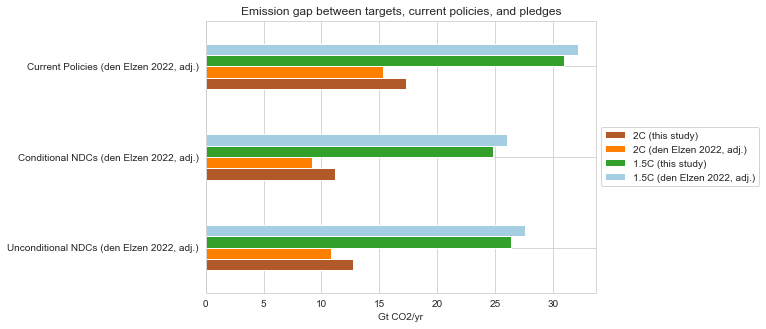

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
order = ['2C (this study)', '2C (den Elzen 2022, adj.)', '1.5C (this study)', '1.5C (den Elzen 2022, adj.)']
gap[order].loc[gap.index[::-1]].plot.barh(cmap='Paired_r', ax=ax)
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.set_ylabel('')
ax.set_xlabel('Gt CO2/yr')
ax.set_title('Emission gap between targets, current policies, and pledges')
fig.savefig('./files/figsi3b.svg', dpi=1200, bbox_inches='tight')

In [19]:
(12.7 - 10.8) / 10.8 # 2C

0.1759259259259258

In [20]:
(26.4 - 27.6) / 27.6

-0.04347826086956532

# Figure 2B

In [21]:
def make_gap_data(df, v, categories_to_temp):
    x = (
        df
        .filter(variable=v, year=[2030])
        .filter(Category=categories_to_temp.keys())
        .as_pandas()
        .replace({'Category': categories_to_temp})
    )
    idx = ['model', 'scenario', 'region', 'year', 'Category']
    x = x.set_index(idx)['value'] 
    return x

def make_gap_plot(data, drop={}, ax=None, palette=None):
    data = data.reset_index().dropna()
    for col, value in drop.items():
        data = data[data[col] != value]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    ax.axhline(0, c='k', ls='--', alpha=0.5)
    palette = palette or {"2C": "#fc8d59", "1.5C":"#91bfdb"}
    sns.boxplot(
        x="region", y="value", hue="Category",
        data=data, 
        palette=palette, ax=ax, showfliers=False, whis=0,
    )
    return ax

In [22]:
# change in emissions in negative, gap is positive
a = 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020'
b = 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020'
adj = -1 * make_gap_data(df, a, categories_to_temp)
orig = -1 * make_gap_data(df, b, categories_to_temp)

<Axes: title={'center': 'region: World - variable: Change in Indirect Component of Flux'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

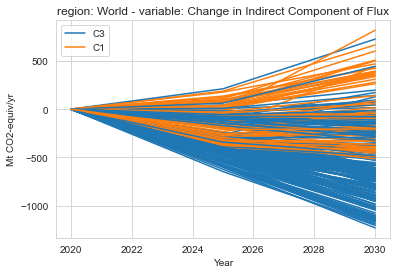

In [23]:
(
    df
    .filter(variable=[a, b], year=range(2020, 2031, 5))
    .subtract(a, b, name='Change in Indirect Component of Flux', ignore_units='Mt CO2-equiv/yr')
    .filter(Category=['C1', 'C3'])
    .filter(region='World')
    .plot.line(color='Category')
)

Note that this calculation differs from that in Figure 2. Here we look at the relative change in emission reductions between both frameworks.

$$\Delta_{model} = E^{GHG}_{model, 2030} - E^{GHG}_{model, 2020}$$
$$\Delta_{NGHGI} = E^{GHG}_{NGHGI, 2030} - E^{GHG}_{NGHGI, 2020}$$

$$metric = 1 - \frac{\Delta^{2030-2020}_{NGHGI}}{\Delta^{2030-2020}_{Model}}$$

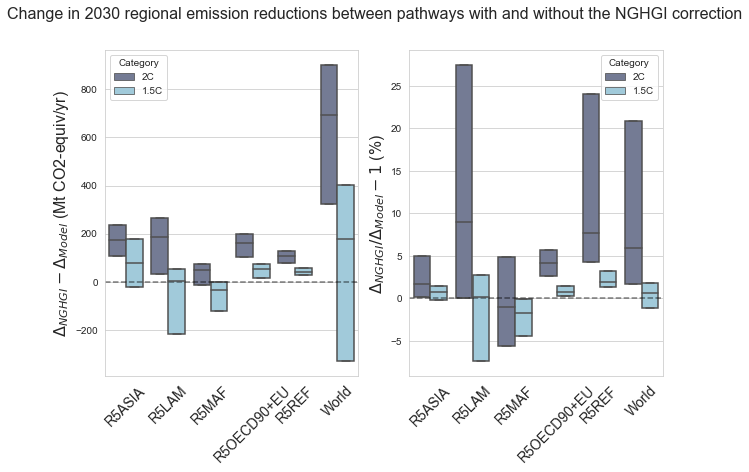

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

ax = axs[0]
make_gap_plot(adj-orig, ax=ax, palette=color_map)#, drop={'region': 'World'}) # World values distort plot
ax.set_xlabel('')
ax.set_ylabel(r"$\Delta_{NGHGI} - \Delta_{Model}$ (Mt CO2-equiv/yr)", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize=14)

ax = axs[1]
make_gap_plot(100 * ((adj / orig) - 1), ax=ax, palette=color_map)
ax.set_xlabel('')
ax.set_ylabel(r"$\Delta_{NGHGI} / \Delta_{Model} - 1$ (%)", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize=14)

fig.suptitle(
    'Change in 2030 regional emission reductions between pathways with and without the NGHGI correction',
    fontsize=16,
)

fig.savefig('./files/figsi3c.svg', dpi=1200, bbox_inches='tight')